# Images

An ``Images`` object is a distributed collection of either 2D images or 3D volumes. It supports several simple manipulations of image content, exporting image data, and conversion to other data formats.

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
from thunder import Colorize
image = Colorize.image

Loading images
--------------
Images can be loaded from a ``ThunderContext`` using the `loadImages` method. See the ``Input Formats`` tutorial for more detail; here, we'll just load example image data.

In [3]:
data = tsc.loadExample('fish-images')

We can inspect the object to see basic properties, like the number of records (which here are images):

In [4]:
data

Images
nrecords: 20
dtype: None (inspect to compute)
dims: None (inspect to compute)

Note that the dimensions and dtype are missing. That's because we haven't computed them yet.

In [5]:
data.dims.max

(75, 86, 1)

In [6]:
data.dims.min

(0, 0, 0)

In [7]:
data.dims.count

(76, 87, 2)

If you now inpsect the object again, you'll see those fields populated. This is an example of a *lazy* operation; because computing the dimensions requires loading data, we don't compute it automatically, but once we have computed it, we keep it around in case we need it again.

In [8]:
data

Images
nrecords: 20
dtype: uint8
dims: min=(0, 0, 0), max=(75, 86, 1), count=(76, 87, 2)

We can also look at the first record, which is a key-value pair. The first entry, the key, is an integer identifier (this is the first image, so it is 0).

In [9]:
data.keys().first()

0

In Images data, a single record usually corresponds to a single input file. The ordering of keys comes from sorting the names of the input files alphanumerically. In a movie, where each image file represents a single time point, ordering file names so that alphabetically later names correspond to later time points (for instance, by appending a postfix '_tp000', '_tp001', etc to a common file name) will cause the resulting Images data to be sorted in temporal order. This will simplify ease conversion into temporally-oriented ``Series`` data and other analyses.

The value of an Images record is the image volume, as an n-dimensional numpy array:

In [10]:
img = data.values().first()
img.shape

(76, 87, 2)

We can look at it as an image. It's three-dimensional, with two planes to look at:

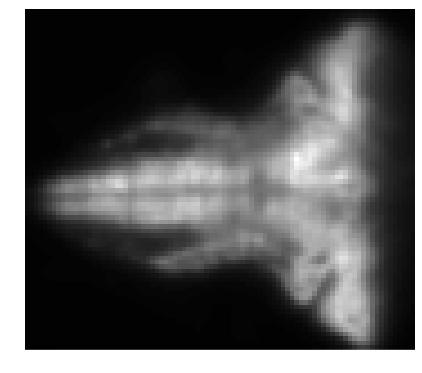

In [11]:
image(img[:,:,0])

Here's the second plane:

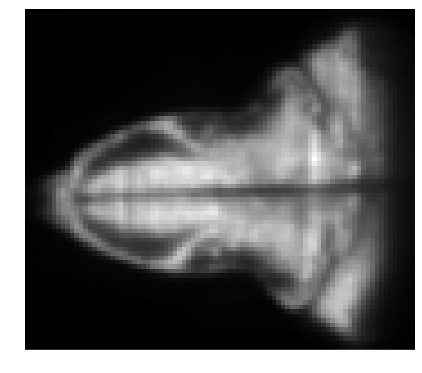

In [12]:
image(img[:,:,1])

As an example of 2D data, we can load another one of the examples

In [13]:
data = tsc.loadExample('mouse-images')
data.dims.count

(64, 64)

Look at the first image

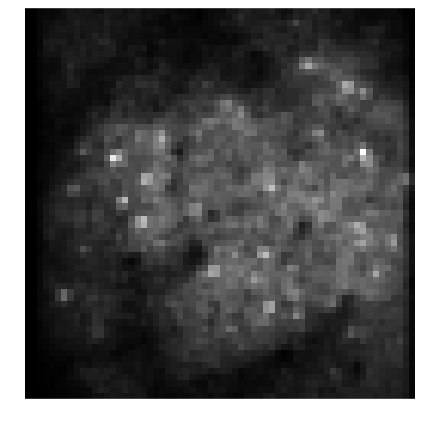

In [14]:
img = data.values().first()
image(img)

Bracket notation makes it easy to grab images with particular indexes, by specifying the key in the bracket

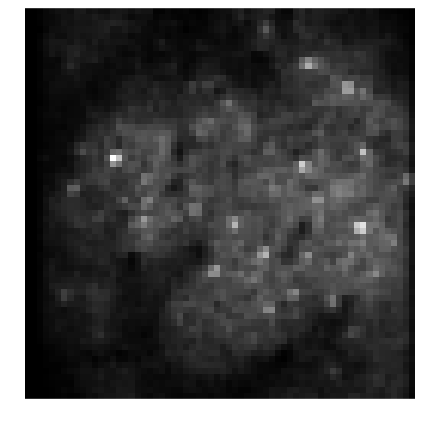

In [15]:
image(data[10])

Image manipulations
-------------------
An ``Images`` object has a variety of methods for image manipulation, all of which are automatically parallelized across images when running on a cluster.

A common manipulation on volumetric data is computing a maximum projection across one dimension. Here, we compute the projections, and then show the first one.

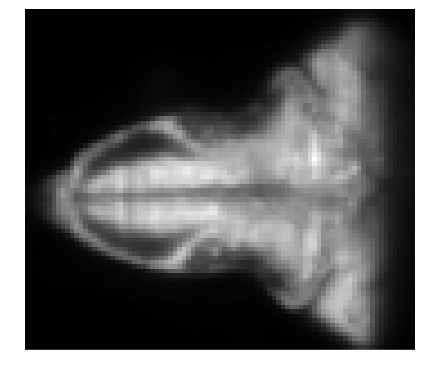

In [16]:
data = tsc.loadExample('fish-images')
projs = data.maxProjection(axis=2)
img = projs.first()[1]
image(img)

We can also subselect a set of planes, specifying the top and bottom of the desired range:

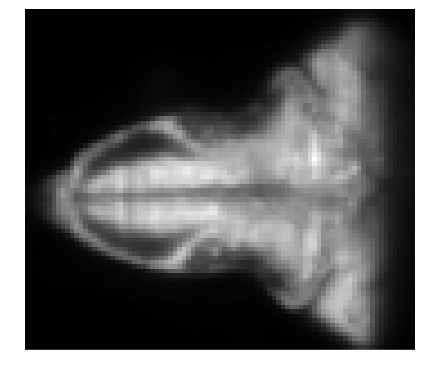

In [17]:
sub = data.planes(0,0).values().first()
image(img)

And we can subsample in space:

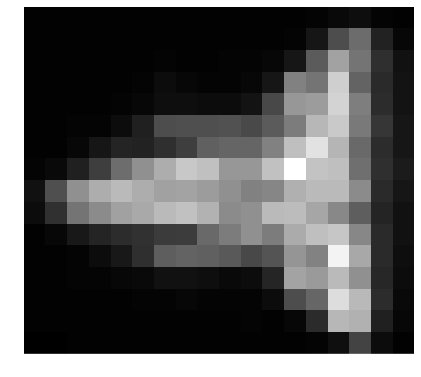

In [18]:
img = data.subsample([5,5,1]).values().first()
image(img[:,:,0])

Finally, we can perform operations that aggregate across images. For example, computing the standard deviation:

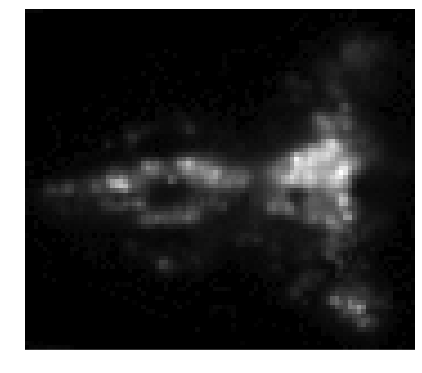

In [19]:
img = data.stdev()
image(img[:,:,0])

The result of distributed image operations can be saved by exporting each image to a `png` file. You can pass the same arguments as to the `matplotlib` function `imshow` (NOTE: This support is currently limited to saving 2D image data.)

```
data.maxProjection().saveAsPngs('directory', vmin=0, vmax=200, cmap='gray')
```

Conversions
-----------
We commonly encounter images or volumes that correspond to different time points, e.g. from a movie. It is useful to convert these data into a `Series` object, the object used in Thunder for distributed one-dimensional array data. After this conversion, the `Series` will be a distributed collection of records, where each record has a pixel identifier as a key, and a time series as a value. 

There are two ways to convert image or volume data into `Series` data. The first is to load ``Images`` data and then convert it into ``Series`` data. This can be done on an ``Images`` object using the `toSeries()` method, and it can also be done in one step using the ``ThunderContext`` method ``loadImagesAsSeries``. Here, we load the example ``Images`` data and convert it to a ``Series``.

In [20]:
data = tsc.loadExample('fish-images')
ts = data.toSeries()
ts.cache();

Let's check some properties of the resulting `Series` to make sure the conversion we did makes sense. We have twenty images, so there should be twenty time points, and the dimensions of the keys should match the dimensions of the original images.

In [21]:
ts.index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [22]:
ts.dims.max

(75, 86, 1)

In [23]:
ts.dims.min

(0, 0, 0)

In [24]:
ts.dims.count

(76, 87, 2)

We can also quickly look at some example time series:

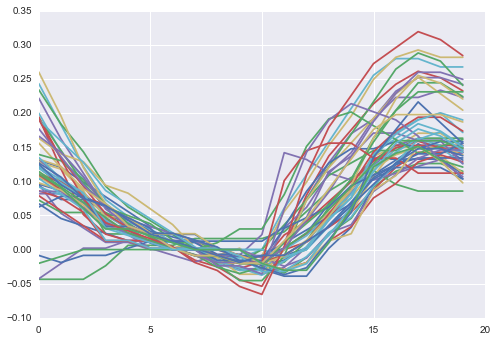

In [25]:
samples = ts.toTimeSeries().normalize().subset(nsamples=50, thresh=0.05)
plt.plot(samples.T);

For a large data set that will be analyzed repeatedly as a `Series`, it will ultimately be faster and more convienient to save `Images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as a ``Series``, rather than repeatedly converting the images to a ``Series`` object. This can be performed directly on an ``Images`` object, as in:

```
data = tsc.loadImages('my-image-directory', inputFormat='tif', startIdx=0, stopIdx=20)
data.saveAsBinarySeries('my-binary-directory', overwrite=True)
ts = tsc.loadSeries('my-binary-directory')
```